In [21]:
import os
from tensorflow import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image

### Path of the dataset

In [22]:
size = (128,128,3)

# for train data
train_path = './dices'
#for test data 
test_path = './dice_test'


batch_size = 16


### Load Images

In [23]:
def load_images(path):
    
    images = []
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path,file))
        if img is not None:
            images.append(img)
    
    plt.figure(figsize=(15,8))    
    for img,x in zip(images,range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

### Normal Dices

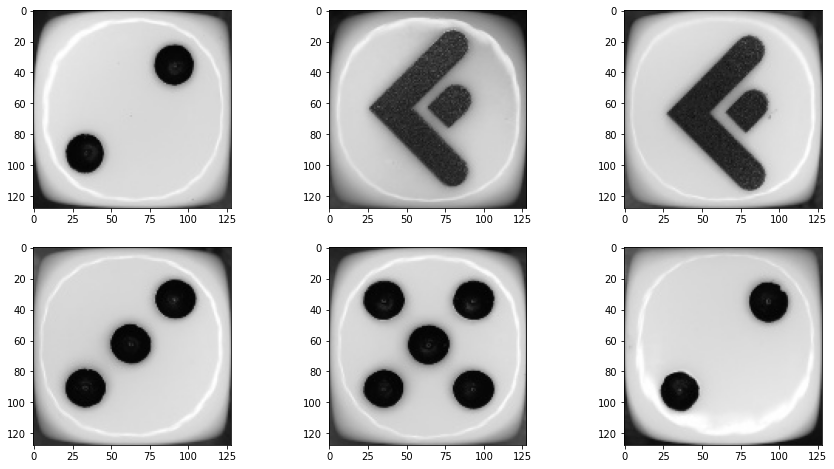

In [24]:
train_normal = './dices/normal'

load_images(train_normal)


### Abnormal Dices

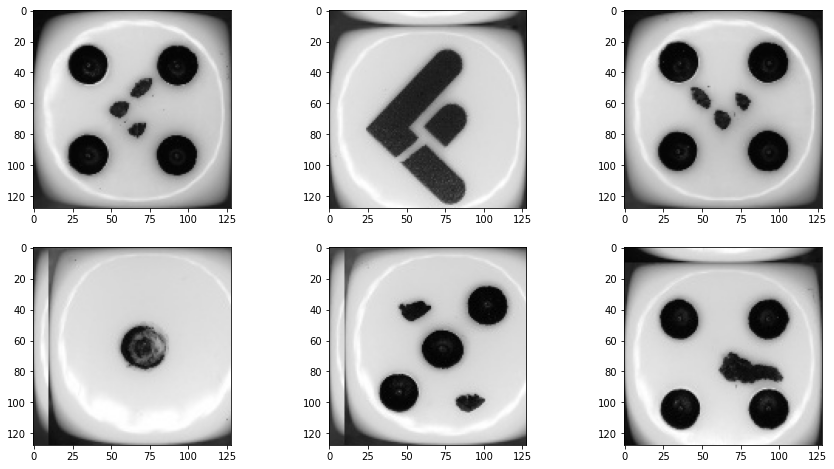

In [25]:
train_abnormal = './dices/abnormal'

load_images(train_abnormal)

### ImageDataGenerator

In [26]:
# Image Data Generator for train set

train_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

# Image Data Generator for test set

test_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

In [27]:
train = train_gen.flow_from_directory(
            train_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'training'
)

test = test_gen.flow_from_directory(
            test_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'validation'
)

Found 3470 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [28]:
test_num = test.samples

label_test = []
for i in range((test_num // test.batch_size)+1):
    X,y = test.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

### Create Model Function

In [56]:
# with optimizer = SGD
def create_model():
    
    model = MobileNet( include_top=False, 
            input_shape=(128,128,3), weights='imagenet')

    x=model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x) #dense layer 3
    preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
    
    model=Model(inputs=model.input,outputs=preds)

    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    model.summary()

    return model

In [65]:
# with optimizer = Adam
def create_adam_model():
    
    model = MobileNet( include_top=False, 
            input_shape=(128,128,3), weights='imagenet')

    x=model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x) #dense layer 3
    preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
    
    model=Model(inputs=model.input,outputs=preds)

    model.compile(loss = "categorical_crossentropy", 
                  optimizer = Adam(lr=0.0001), metrics=["accuracy"])
    model.summary()

    return model

### Save Model - Callbacks

In [60]:
#save the model
checkpoint_path = "adam_mobilenet.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# create callbacks with check point
callbacks = [EarlyStopping(monitor='accuracy', patience=22, verbose=1, mode='auto'),
             ModelCheckpoint(checkpoint_path, monitor='accuracy', 
             save_best_only=True, save_weights_only=False, mode='auto')]


### Fit Model

In [82]:
model = create_model()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

/Users/yusufakcakaya/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
model = create_adam_model()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

In [37]:
steps_per_epoch= train.samples/train.batch_size

In [38]:
# with SGD optimiser
history = model.fit(train, steps_per_epoch= 100, 
                           epochs= 5, callbacks= callbacks)

Epoch 1/5
100/100 [==============================] - 31s 301ms/step - loss: 0.2977 - accuracy: 0.8875
Epoch 2/5
100/100 [==============================] - 31s 306ms/step - loss: 0.1054 - accuracy: 0.9756
Epoch 3/5
100/100 [==============================] - 30s 304ms/step - loss: 0.0664 - accuracy: 0.9831
Epoch 4/5
100/100 [==============================] - 30s 302ms/step - loss: 0.0464 - accuracy: 0.9887
Epoch 5/5
100/100 [==============================] - 30s 304ms/step - loss: 0.0397 - accuracy: 0.9912


In [83]:
# with adam optimiser 
history = model.fit(train, steps_per_epoch= 100,validation_data= test,
                           epochs= 5, callbacks= callbacks)


Epoch 1/5
100/100 [==============================] - 33s 321ms/step - loss: 0.0586 - accuracy: 0.9812 - val_loss: 0.6904 - val_accuracy: 0.8772
Epoch 2/5
100/100 [==============================] - 34s 339ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0931 - val_accuracy: 0.9474
Epoch 3/5
100/100 [==============================] - 34s 339ms/step - loss: 0.0071 - accuracy: 0.9969 - val_loss: 0.1128 - val_accuracy: 0.9386
Epoch 4/5
100/100 [==============================] - 46s 461ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.0695 - val_accuracy: 0.9825
Epoch 5/5
100/100 [==============================] - 48s 482ms/step - loss: 0.0299 - accuracy: 0.9875 - val_loss: 0.0041 - val_accuracy: 1.0000


### Classification Report

In [39]:
#with SGD optimiser
print(classification_report(label_test, np.argmax(model.predict(test),axis=1)))


              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.96      0.99      0.98        99

    accuracy                           0.96       114
   macro avg       0.94      0.86      0.89       114
weighted avg       0.95      0.96      0.95       114



In [70]:
# with adam optimiser
print(classification_report(label_test, np.argmax(model.predict(test),axis=1)))


              precision    recall  f1-score   support

           0       0.06      0.07      0.06        15
           1       0.86      0.85      0.85        99

    accuracy                           0.75       114
   macro avg       0.46      0.46      0.46       114
weighted avg       0.75      0.75      0.75       114



In [84]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Plot Model

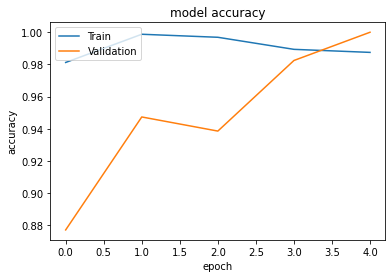

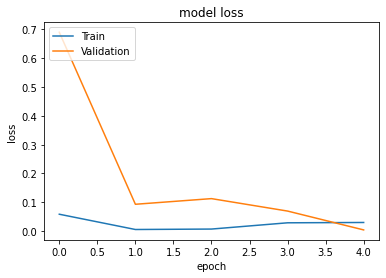

In [85]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Prediction

In [73]:
def predict(path):
    img = image.load_img(path, target_size=(128, 128))
    
    # Preprocessing the image
    pp_img = image.img_to_array(img)
    pp_img = pp_img/255
    pp_img = np.expand_dims(pp_img, axis=0)
    
    #Load Model
    saved_model = load_model("mobilenet.h5")

    #predict
    img_pred= saved_model.predict(pp_img)
    
    
    if img_pred[0][0] >= 0.5: 
        pred = ('Abnormal : {:%} percent'.format(img_pred[0][0]))
    
    else: 
        pred = ('Normal : {:%} percent'.format(1- img_pred[0][0]))
        
    plt.title("Dice Anomaly Detection\n"+ pred)  

    plt.imshow(np.squeeze(pp_img))
    
    return  plt.show()

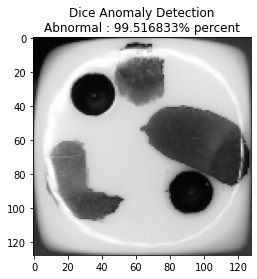

In [74]:
path = './dices/abnormal/img_00710_cropped.jpg'
predict(path)

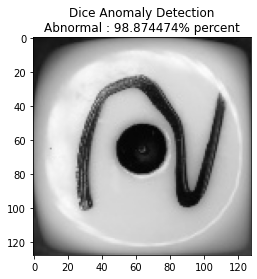

In [75]:
path = './dices/abnormal/17_11_21_anomalies_012.png'
predict(path)

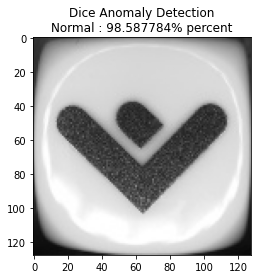

In [76]:
path = './dices/normal/26_01_22_10_107.png'
predict(path)

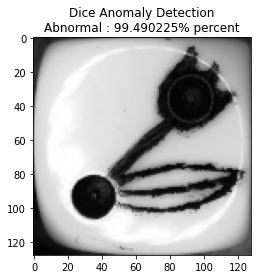

In [77]:
path = './dices/abnormal/img_02864_cropped.jpg'
predict(path)

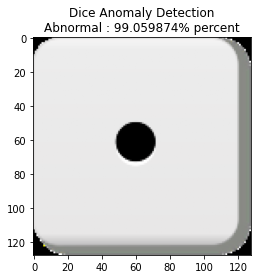

In [78]:
path = './test/pngegg.png'
predict(path)

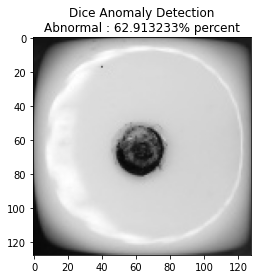

In [79]:
path = './test/17_11_21_anomalies_045.png'
predict(path)

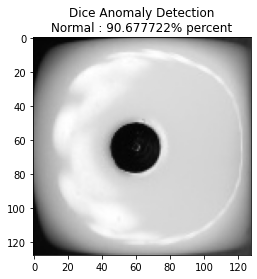

In [50]:
path = './test/unknown.png'
predict(path)

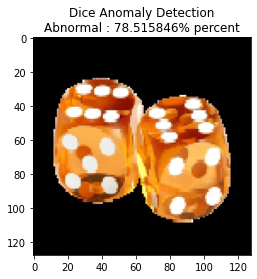

In [51]:
path = './test/pngegg (2).png'
predict(path)

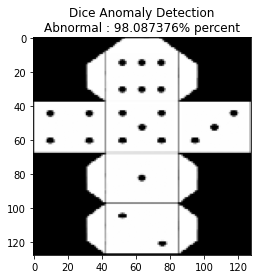

In [52]:
path = './test/pngegg (6).png'
predict(path)

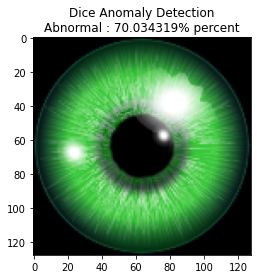

In [53]:
path = './test/pngegg (7).png'
predict(path)

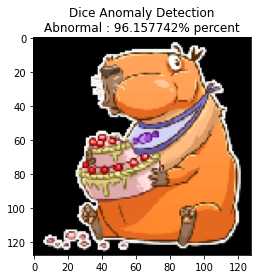

In [54]:
path = './test/pngegg (8).png'
predict(path)

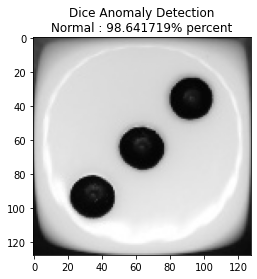

In [55]:
path = './test/26_01_22_03_195.png'
predict(path)

- **include_top (True)**: Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.
- **weights (‘imagenet‘)**: What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.
- **input_tensor (None)**: A new input layer if you intend to fit the model on new data of a different size.
- **input_shape (None)**: The size of images that the model is expected to take if you change the input layer.
- **pooling (None)**: The type of pooling to use when you are training a new set of output layers.
- **classes (1000)**: The number of classes (e.g. size of output vector) for the model.

**Transfer learning is simple**: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction. The idea is the convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image such as eyes or wheels.

There are two ways of using Transfer Learning, Feature-Extraction and Fine-Tuning

The entire pre-trained model is frozen, which means the weights are not updated, and the learning process is halted

This project imported the VGG architecture allowing training of the last two convolutional blocks. This will permit our model to specialize in our classification task. For this purpose, we’ve also excluded the top layers of the original model replacing them with another structure

**Calculate steps_per_epoch** : steps_per_epoch=train.samples/train.batch_size(3470/16 = 216.875)


- Momentum accelerates the training process but adds an additional hyperparameter.